#Importing Libraries and reading required files

In [2]:
#importing necessary files and modules
import pandas as pd
from os import listdir
from matplotlib import pyplot
from matplotlib.image import imread
from sklearn import preprocessing
import os

from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import requests

In [3]:
#read labels data from csv
labels=pd.read_csv("/content/drive/MyDrive/Dogclassifier/labels.csv")

In [4]:
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


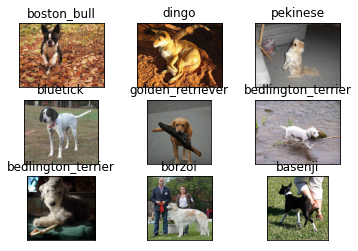

In [5]:
# plot some dog photos with labels as example of dataset

folder = '/content/drive/MyDrive/Dogclassifier/train/'
for i in range(0,9):
    pyplot.subplot(330 + 1 + i)
    filename = folder + str(labels["id"][i]) + '.jpg'
    image = imread(filename)
    pyplot.imshow(image)
    pyplot.xticks([])
    pyplot.yticks([])
    pyplot.title(labels["breed"][i])
pyplot.show()

In [6]:
#creating list of train labels
dict = {labels["id"][i]: labels["breed"][i] for i in range(0, len(labels), 2)}

folder = '/content/drive/MyDrive/Dogclassifier/train/'
train_labels = list()
for file in listdir(folder):
    if(str(file[:-4]) in dict):
        train_labels.append(str(dict[str(file[:-4])]))

#Pre - processing data 

In [7]:
#function to return unique labels from list
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return (unique_list)

In [8]:
le = preprocessing.LabelEncoder()
le.fit(train_labels)
label = le.transform(train_labels)
u_labels = unique(train_labels)

#Mapping

In [9]:
# map each image path to their class label in 'data'
dataset_home = '/content/drive/MyDrive/Dogclassifier/content'
data = {}

for l in u_labels:
    for img in os.listdir(dataset_home+'/train/'+l):
       data.update({os.path.join(dataset_home,'train', l, img): l})

In [17]:
Train_dir = '/content/drive/MyDrive/Dogclassifier/content/train'
Batch_size = 64
Num_classes=len(u_labels)
Input_shape = (224, 224, 3)
Class_mode = 'categorical'
epochs=100

In [11]:
# Create a ImageDataGenerator Instance which can be used for data augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True,
    validation_split=0.2
)

#training data
train_generator = train_gen.flow_from_directory(
    directory=Train_dir,
    target_size=(224, 224),
    batch_size=Batch_size,
    class_mode=Class_mode,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)

#subset used for validation 
# validation_generator = train_gen.flow_from_directory(
#     directory=Train_dir, # same directory as training data
#     target_size=(224, 224),
#     batch_size=Batch_size,
#     class_mode=Class_mode,
#     subset='validation',
#     color_mode='rgb',
#     shuffle=True,
#     seed=69)

Found 5111 images belonging to 120 classes.


In [12]:
#List of Training labels
print(train_generator.class_indices)

{'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_pointer': 47, 'gian

#CNN Model

In [13]:
#import tensorflow, keras and other modules
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras.callbacks import ReduceLROnPlateau

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input
from keras.applications import xception
from tensorflow.keras.applications.xception import preprocess_input,decode_predictions

In [14]:
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5)

In [ ]:
# Using pre-trained Xception model for transfer learning
base_model = xception.Xception(weights='imagenet', include_top=False)

# average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# prediction layer 
predictions = Dense(Num_classes, activation='softmax')(x)

# model to be trained
model = Model(inputs=base_model.input, outputs=predictions)

# freeze Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=["accuracy"])


83697664/83683744 [==============================] - 1s 0us/step


In [15]:
model2 = keras.models.load_model('/content/drive/MyDrive/Dogclassifier/saved_model_2')

In [18]:
#training model
model2.fit_generator(train_generator,epochs = epochs, #validation_data = validation_generator, callbacks=[lrr], 
                    verbose = 1,shuffle = True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
80/80 [==============================] - 1524s 19s/step - loss: 0.7273 - accuracy: 0.7922
Epoch 2/100
80/80 [==============================] - 76s 949ms/step - loss: 0.6930 - accuracy: 0.7971
Epoch 3/100
80/80 [==============================] - 76s 948ms/step - loss: 0.7596 - accuracy: 0.7861
Epoch 4/100
80/80 [==============================] - 76s 952ms/step - loss: 0.7447 - accuracy: 0.7875
Epoch 5/100
80/80 [==============================] - 76s 950ms/step - loss: 0.6986 - accuracy: 0.7950
Epoch 6/100
80/80 [==============================] - 77s 959ms/step - loss: 0.6871 - accuracy: 0.8002
Epoch 7/100
80/80 [==============================] - 77s 961ms/step - loss: 0.7069 - accuracy: 0.7963
Epoch 8/100
80/80 [==============================] - 78s 976ms/step - loss: 0.7244 - accuracy: 0.7905
Epoch 9/100
80/80 [==============================] - 79s 980ms/step - loss: 0.7094 - accuracy: 0.7914
Epoch 10/100
80/80 [==============================] - 80s 1s/step - loss: 0.7182 -

In [19]:
#saving model
model2.save('/content/drive/MyDrive/Dogclassifier/saved_model_2')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Dogclassifier/saved_model_2/assets


In [20]:
#Setting up test dataset
Test_dir = '/content/drive/MyDrive/Dogclassifier/test_images'
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    directory=r"/content/drive/MyDrive/Dogclassifier/test_images",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=69)

Found 10357 images belonging to 1 classes.


#Predictions

In [21]:
#probability prediction for test dataset
probabilities = model2.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [22]:
folder = '/content/drive/MyDrive/Dogclassifier/test_images/test'
test_labels = list()
for file in listdir(folder):
        test_labels.append(str(file[:-4]))

columns=['id']
columns.extend(list(train_generator.class_indices.keys()))

In [23]:
data = []
for i in range(0,len(probabilities)):
  data.append([test_labels[i],*probabilities[i]])
df = pd.DataFrame(data)
df.columns = columns

In [24]:
# csv file for submission
df.to_csv('/content/drive/Dogclassifier/submissions.csv',index =False)

In [25]:
#predict from url of image
url = 'https://www.dogtime.com/assets/uploads/2011/01/file_23138_boston-terrier-460x290.jpg'
breed_list = list(train_generator.class_indices.keys())

im = Image.open(requests.get(url, stream=True).raw)
img_batch = np.expand_dims(im, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model2.predict(preprocess_input(img_preprocessed))
pred = (-prediction).argsort()[0][0:5]
print("Most Likely Breeds: ")
for i in pred:
  print(breed_list[i])

Most Likely Breeds: 
boston_bull
italian_greyhound
toy_poodle
french_bulldog
pug
